In [18]:
# Importing necessary libraries
import zipfile
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import seaborn as sns
from PIL import Image

In [2]:
# Assuming you have uploaded the dataset.zip to the Colab session storage
zip_path = '/content/dataset.zip'

# Unzipping the dataset
print("Unzipping the dataset...")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content')
print("Dataset unzipped successfully.")

Unzipping the dataset...
Dataset unzipped successfully.


In [3]:
# Set up paths to the training and testing directories
train_dir = '/content/Training'
test_dir = '/content/Testing'

In [4]:
# Check the number of images in each directory
print("\nDirectory structure and class counts:")
for dirpath, dirnames, filenames in os.walk('/content/dataset'):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")


Directory structure and class counts:
There are 2 directories and 0 images in '/content/dataset'.
There are 4 directories and 0 images in '/content/dataset/Training'.
There are 0 directories and 1339 images in '/content/dataset/Training/meningioma'.
There are 0 directories and 1457 images in '/content/dataset/Training/pituitary'.
There are 0 directories and 1595 images in '/content/dataset/Training/notumor'.
There are 0 directories and 1321 images in '/content/dataset/Training/glioma'.
There are 4 directories and 0 images in '/content/dataset/Testing'.
There are 0 directories and 306 images in '/content/dataset/Testing/meningioma'.
There are 0 directories and 300 images in '/content/dataset/Testing/pituitary'.
There are 0 directories and 405 images in '/content/dataset/Testing/notumor'.
There are 0 directories and 300 images in '/content/dataset/Testing/glioma'.


In [5]:
# Create an ImageDataGenerator for preprocessing and augmenting the training set
print("\nSetting up data generators with preprocessing...")
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to [0, 1]
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Only rescaling for the test set
test_datagen = ImageDataGenerator(rescale=1./255)


Setting up data generators with preprocessing...


In [6]:
# Prepare generators for training data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    # Resize images for consistent input size
    target_size=(150, 150),
    batch_size=20,
    class_mode='categorical',
    # Shuffle data for random access
    shuffle=True
)

Found 5712 images belonging to 4 classes.


In [7]:
# Prepare generators for testing data
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='categorical',
    shuffle=True
)

Found 1311 images belonging to 4 classes.


In [8]:
# Function to plot images in a 1x4 grid
def plot_images(images, labels):
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    axes = axes.flatten()
    for img, lbl, ax in zip(images, labels, axes):
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f"Class: {lbl}")
    plt.tight_layout()
    plt.show()

In [9]:
# Plot sample images from each class
classes = list(train_generator.class_indices.keys())

# Get a batch of images
sample_images, sample_labels = next(train_generator)

In [10]:
# Select one image from each class to display
print("\nDisplaying sample images from each class:")
unique_labels = np.unique(np.argmax(sample_labels, axis=1), return_index=True)[1]
images_to_display = sample_images[unique_labels]
labels_to_display = [classes[np.argmax(lbl)] for lbl in sample_labels[unique_labels]]



Displaying sample images from each class:


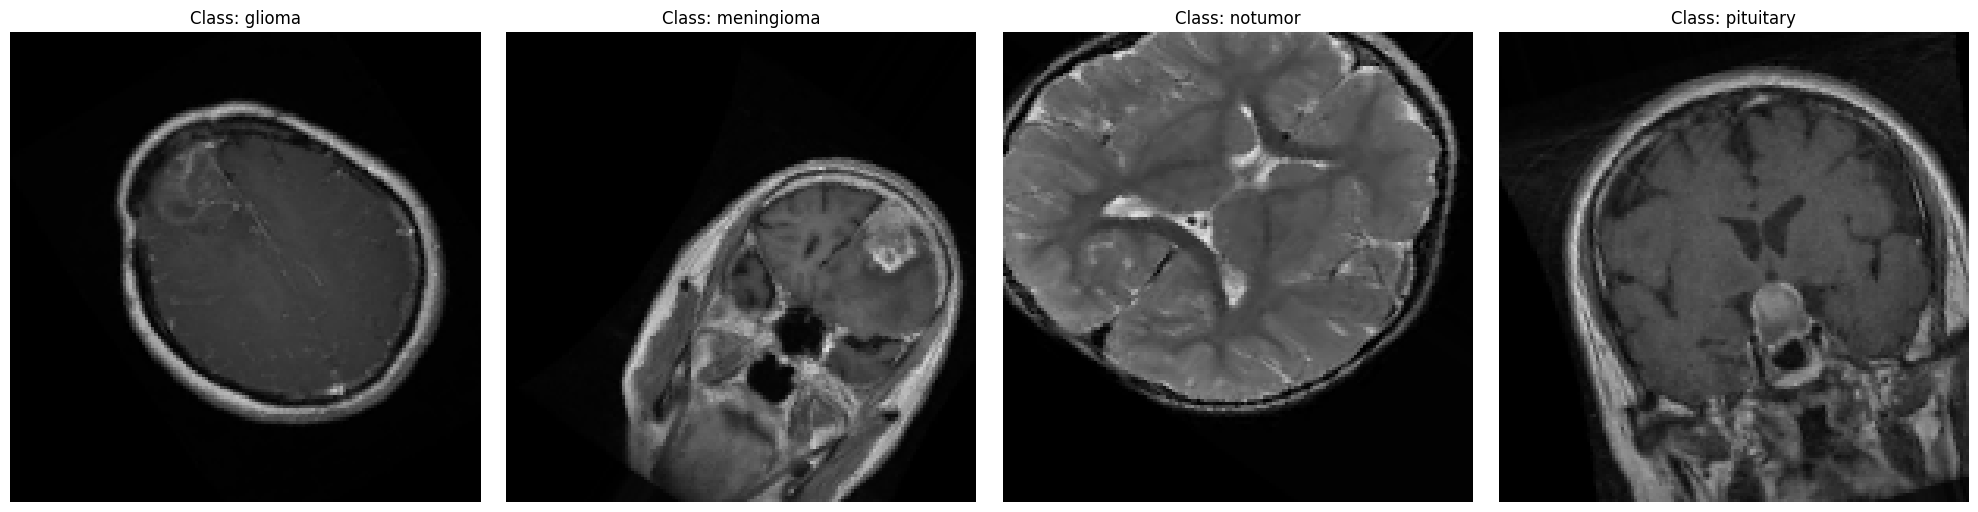

In [11]:
# Call function to plot images
plot_images(images_to_display, labels_to_display)

In [12]:
# Function to count images per class
def count_images(dir_path):
    counts = {}
    for class_folder in os.listdir(dir_path):
        class_folder_path = os.path.join(dir_path, class_folder)
        if os.path.isdir(class_folder_path):
            counts[class_folder] = len(os.listdir(class_folder_path))
    return counts

In [13]:
# Count images in each dataset
train_counts = count_images(train_dir)
test_counts = count_images(test_dir)

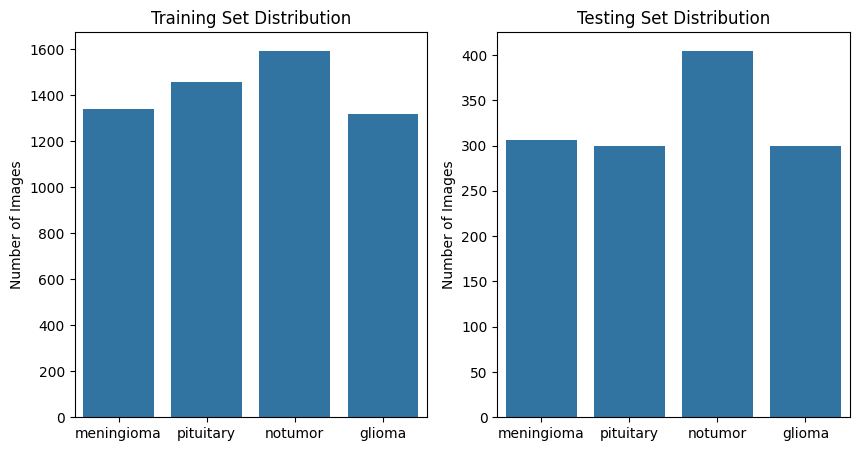

In [16]:
# Displaying the class distribution in training and testing datasets
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.barplot(x=list(train_counts.keys()), y=list(train_counts.values())).set_title('Training Set Distribution')
plt.ylabel('Number of Images')
plt.subplot(1, 2, 2)
sns.barplot(x=list(test_counts.keys()), y=list(test_counts.values())).set_title('Testing Set Distribution')
plt.ylabel('Number of Images')
plt.show()

In [21]:
# Calculate and display average image size per class in the training set
def calculate_avg_img_size(directory):
    sizes = []
    for class_folder in os.listdir(directory):
        class_folder_path = os.path.join(directory, class_folder)
        if os.path.isdir(class_folder_path):
            for img_name in os.listdir(class_folder_path):
                img_path = os.path.join(class_folder_path, img_name)
                with Image.open(img_path) as img:
                    # size is in (width, height)
                    sizes.append(img.size)
    avg_size = np.mean(sizes, axis=0)
    return avg_size

avg_size_train = calculate_avg_img_size(train_dir)
print(f"Average Image Size in Training Set: width: {avg_size_train[0]} height: {avg_size_train[1]}")

avg_size_test = calculate_avg_img_size(test_dir)
print(f"Average Image Size in Testing Set: width: {avg_size_test[0]} height: {avg_size_test[1]}")

Average Image Size in Training Set: width: 451.563200280112 height: 453.8837535014006
Average Image Size in Testing Set: width: 421.1800152555301 height: 424.2227307398932


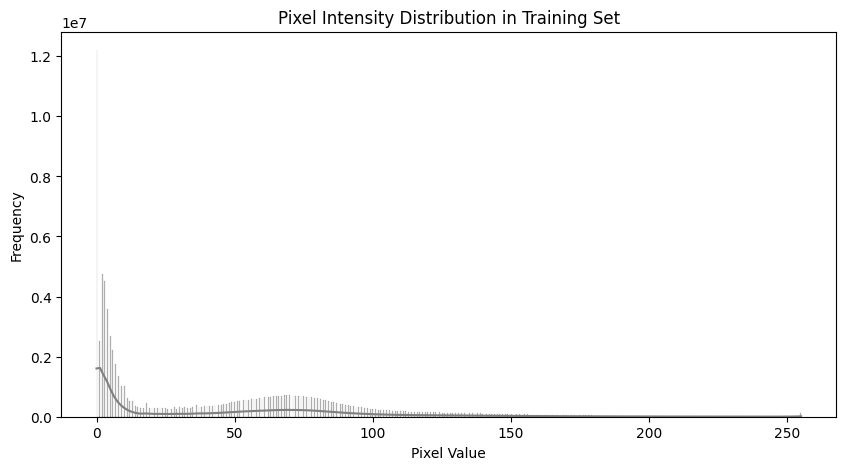

In [22]:
# Function to plot image intensity distribution
def plot_intensity_distribution(directory, num_images=100):
    intensities = []

    for class_folder in os.listdir(directory):
        class_folder_path = os.path.join(directory, class_folder)
        if os.path.isdir(class_folder_path):
            for i, img_name in enumerate(os.listdir(class_folder_path)):
                if i >= num_images:
                    break
                img_path = os.path.join(class_folder_path, img_name)
                with Image.open(img_path) as img:
                    img_gray = img.convert('L')
                    intensities.extend(np.array(img_gray).flatten())

    plt.figure(figsize=(10, 5))
    sns.histplot(intensities, kde=True, color='gray')
    plt.title('Pixel Intensity Distribution in Training Set')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.show()

# Plot image intensity distribution for training set
plot_intensity_distribution(train_dir)